In [1]:
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import cm as cmap
from mpl_toolkits.mplot3d import Axes3D


#working in weak lensing domain, 3d, with mass distributed across distance

class location:
    def __init__(self,x=0,y=0,z=0):
        self.x = x
        self.y = y
        self.z = z
        
    def dl2(self,dx,dy,dz):
        self.x += dx
        self.y += dy
        self.z += dz
        return dx**2+dy**2+dz**2

class mass:
    def __init__(self,mass,x,y,z):
        self.mass = mass
        self.loc = location(x,y,z)


def bend(dist, mass):
    angle = mass/dist #units chosen such that 4G/c^2 = 1
    if(angle>0.2): #so weak lensing dist >> 2GM/c^2 = mass/2
        print(str(mass)+" mass is within strong lensing domain")
    return angle

#redshift is distance light has traversed (pathlength)
#massdistr sorted by proximity to observer (z)
#make sure massdistr doesn't extend past z of source
def beam(plot, magnifications, redshift, massdistr, xangle, yangle):
    magnification =1
    loc = location()
    totaldz = redshift/np.sqrt(1 + np.sin(xangle)**2 + np.sin(yangle)**2)
    if(plot):
        apparentloc = location(totaldz*np.sin(xangle), totaldz*np.sin(yangle), totaldz)
        fig = plt.figure(1, figsize=(8,8))
        az = fig.add_subplot(111, projection='3d')
        az.plot([loc.x], [loc.y], 'ro',zs=loc.z, label="mass distribution")
        az.plot([loc.x],[loc.y], 'o',zs=loc.z,label="observer")
        az.plot([apparentloc.x],[apparentloc.y],'o',zs=apparentloc.z,label="apparent source")
        az.plot([loc.x,apparentloc.x],[loc.y,apparentloc.y],'orange',zs=[loc.z,apparentloc.z],label="apparent path")
        az.set_xlabel("x distance from observer")
        az.set_ylabel("y distance from observer")
        az.set_zlabel("z distance from observer")

        fig2 = plt.figure(2, figsize=(8,8))
        ay = plt.subplot(111)
        plt.plot(loc.x,loc.z,'ro', label="mass distribution")
        plt.plot(loc.x,loc.z,'o',label="observer")
        plt.plot(apparentloc.x,apparentloc.z,'o',label="apparent source")
        plt.plot([loc.x,apparentloc.x],[loc.z,apparentloc.z],'orange',label="apparent path")
        plt.xlabel("x distance from observer")
        plt.ylabel("z distance from observer")

        fig3 = plt.figure(3, figsize=(8,8))
        ax = plt.subplot(111)
        plt.plot(loc.y,loc.z,'ro', label="mass distribution")
        plt.plot(loc.y,loc.z,'o',label="observer")
        plt.plot(apparentloc.y,apparentloc.z,'o',label="apparent source")
        plt.plot([loc.y,apparentloc.y],[loc.z,apparentloc.z],'orange',label="apparent path")
        plt.xlabel("y distance from observer")
        plt.ylabel("z distance from observer")
        
        locrecord = [(loc.x,loc.y,loc.z)]

    for m in massdistr:
        dz = m.loc.z - loc.z
        dx = dz*np.sin(xangle)
        dy = dz*np.sin(yangle)
        redshift -= np.sqrt(loc.dl2(dx,dy,dz)) #update ray location and pathlength
        if(plot):
            locrecord.append((loc.x,loc.y,loc.z))
            plt.figure(1)
            az.plot([m.loc.x], [m.loc.y], 'ro',zs=m.loc.z, markersize = 10*m.mass)
            az.plot([m.loc.x, loc.x], [m.loc.y, loc.y], 'r--',zs=[m.loc.z, loc.z])
            plt.figure(2)
            plt.plot(m.loc.x, m.loc.z, 'ro', markersize = 10*m.mass)
            plt.plot([m.loc.x, loc.x], [m.loc.z, loc.z], 'r--')
            plt.figure(3)
            plt.plot(m.loc.y, m.loc.z, 'ro', markersize = 10*m.mass)
            plt.plot([m.loc.y, loc.y], [m.loc.z, loc.z], 'r--')
        xdist = loc.x-m.loc.x #calculate bend angle
        ydist = loc.y-m.loc.y
        mdist = np.sqrt(xdist**2 + ydist**2)
        angle = bend(mdist, m.mass)
        dz_LS = totaldz-loc.z #calculate magnification
        dz_S = dz+dz_LS
        thetaE2 = m.mass*dz_LS/(dz*dz_S)
        theta = np.arcsin(np.sqrt(np.sin(xangle)**2 + np.sin(yangle)**2))
        beta = theta-angle*dz_LS/dz_S
        u2 = thetaE2 / beta**2
        stepmag = (u2 +2)/(2*np.sqrt(u2)*np.sqrt(u2 +4)) + 1/2
        if(theta**2 < thetaE2):
            stepmag -= 1
        magnification *= stepmag
        if(plot):
            print(str(m.mass)+" mass magnifies by "+str(stepmag))
        xangle -= angle*xdist/mdist #adjust angles
        yangle -= angle*ydist/mdist #do these two lines require small angle approximation?
    dz = redshift/np.sqrt(1 + np.sin(xangle)**2 + np.sin(yangle)**2)
    loc.x += dz*np.sin(xangle)
    loc.y += dz*np.sin(yangle)
    loc.z += dz
    if(plot):
        print("for a total magnification of "+str(magnification))
        locrecord.append((loc.x,loc.y,loc.z))
        xs = [l[0] for l in locrecord]
        ys = [l[1] for l in locrecord]
        zs = [l[2] for l in locrecord]
        plt.figure(1)
        plt.title("3-dimensional view")
        az.plot(xs ,[l[1] for l in locrecord],'g',zs=zs,label="light ray path")
        az.plot([loc.x],[loc.y], 'go', zs=loc.z, label="true source")
        az.legend()
        plt.figure(2)
        plt.title("projection on y=0 plane")
        plt.plot(xs, zs,'g',label="light ray path")
        plt.plot(loc.x,loc.z,'go',label="true source")
        plt.legend()
        plt.figure(3)
        plt.title("projection on x=0 plane")
        plt.plot(ys, zs,'g',label="light ray path")
        plt.plot(loc.y,loc.z,'go',label="true source")
        plt.legend()
        plt.show()
    magnifications.append(magnification)
    return loc #final x,y,z

0.01588888888888889
0.7241245136186772
60.00000000000468
0.7241245136186772 mass magnifies by 1.2409302579137664
for a total magnification of 1.2409302579137664


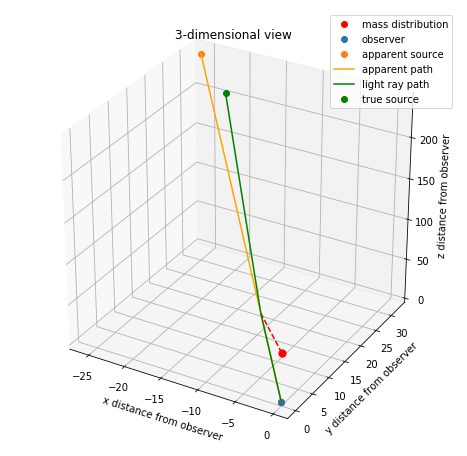

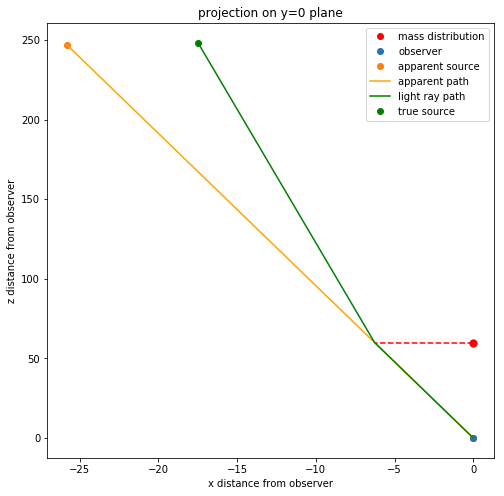

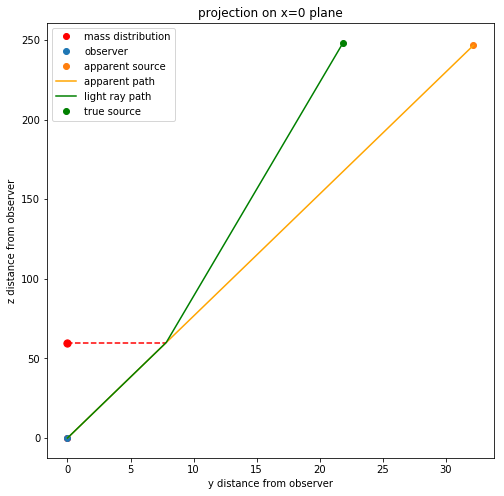

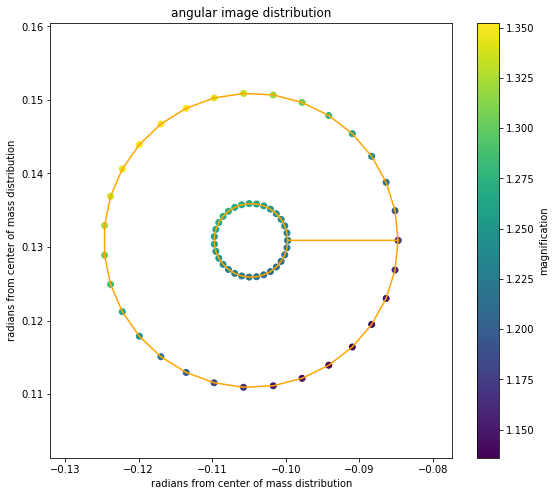

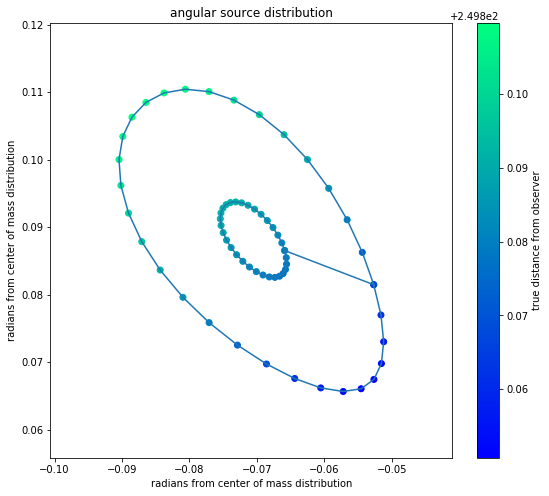

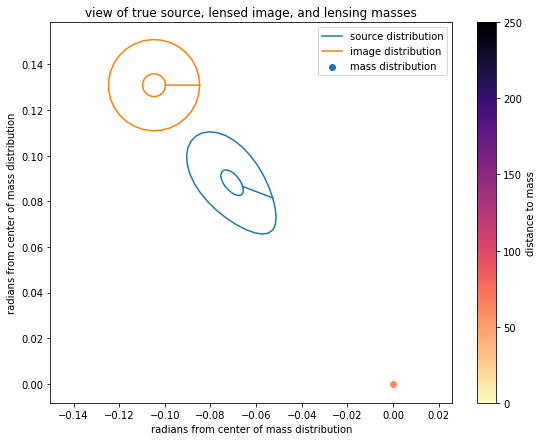

In [20]:
def imagesource(mags, massdistr, imagedistr, redshift, sourcezs):
    sourcedistr = []
    for xy in imagedistr:
        loc = beam(False,mags,redshift,sorted(massdistr, key=lambda m: m.loc.z),xy[0],xy[1])
        truexangle = np.arcsin(loc.x/loc.z)
        trueyangle = np.arcsin(loc.y/loc.z)
        sourcezs.append(loc.z)
        trueangle = (truexangle,trueyangle)
        sourcedistr.append(trueangle)
    return sourcedistr

def center(massdistr):
    centerx = 0
    centery = 0
    totalmassdist = 0
    for m in massdistr:
        centerx += m.mass*m.loc.x/m.loc.z
        centery += m.mass*m.loc.y/m.loc.z
        totalmassdist += m.mass/m.loc.z
    centerx /= totalmassdist
    centery /= totalmassdist
    print(totalmassdist)
    for m in massdistr:
        m.loc.x -= centerx
        m.loc.y -= centery
    return

def collapse(massdistr):
    z=0
    exptotalmassdist = 0
    totalmassdist = 0
    weight = 0
    for m in massdistr:
        exptotalmassdist += m.mass*np.exp(-m.loc.z)
        totalmassdist += m.mass*m.loc.z**2
    for m in massdistr:
        z += m.mass*m.loc.z*np.exp(-m.loc.z)
        weight += m.mass**2*m.loc.z**2
    bigolmass = mass(weight/totalmassdist,0,0,z/exptotalmassdist)
    print(bigolmass.mass)
    print(bigolmass.loc.z)
    return bigolmass

redshift =250
massdistr = [mass(0.3,3,-2,60),mass(0.5,-3,-4,90),mass(0.8,-4,5,150)]
center(massdistr)
massdistr = [collapse(massdistr)]
apparentxangle = -np.pi/30
apparentyangle = np.pi/24
loc = beam(True, [], redshift,sorted(massdistr, key=lambda m: m.loc.z),apparentxangle,apparentyangle)
truexangle = np.arcsin(loc.x/loc.z)
trueyangle = np.arcsin(loc.y/loc.z)
zs = []
mags = []
thetas = np.linspace(0,2*np.pi,32)
image = [(apparentxangle + 0.02*np.cos(theta), apparentyangle + 0.02*np.sin(theta)) for theta in thetas]
image += [(apparentxangle + 0.005*np.cos(theta), apparentyangle + 0.005*np.sin(theta)) for theta in thetas]
source = imagesource(mags,massdistr,image,redshift,zs)

imagefig = plt.figure(4,figsize=(9,8))
i = plt.subplot(111)
npmags =np.array(mags)
ximage = [pt[0] for pt in image]
yimage = [pt[1] for pt in image]
plt.scatter(ximage,yimage, c = mags, cmap="viridis")
plt.plot(ximage,yimage,"orange")
plt.axis('equal')
plt.title("angular image distribution")
plt.clim(npmags.min(),npmags.max())
cbar = plt.colorbar()
cbar.set_label("magnification")
plt.xlabel("radians from center of mass distribution")
plt.ylabel("radians from center of mass distribution")

sourcefig = plt.figure(5,figsize=(9,8))
s = plt.subplot(111)
xsource = [pt[0] for pt in source]
ysource = [pt[1] for pt in source]
sourcedists = np.array([zs[n]*np.sqrt(1+np.sin(source[n][0])**2+np.sin(source[n][1])**2) for n in range(0,len(zs))])
plt.scatter(xsource,ysource, c= sourcedists, cmap="winter")
plt.plot(xsource,ysource)
plt.axis('equal')
plt.clim(sourcedists.min(),sourcedists.max())
cbar = plt.colorbar()
cbar.set_label("true distance from observer")
plt.title("angular source distribution")
plt.xlabel("radians from center of mass distribution")
plt.ylabel("radians from center of mass distribution")

combfig = plt.figure(6, figsize=(9,7))
comb = plt.subplot(111)
plt.plot(xsource,ysource,label="source distribution")
plt.plot(ximage,yimage,label="image distribution")
masszs = np.array([m.loc.z for m in massdistr])
plt.scatter([np.arctan(m.loc.x/m.loc.z) for m in massdistr],[np.arctan(m.loc.y/m.loc.z) for m in massdistr],c=masszs,cmap='magma_r',label="mass distribution")
plt.clim(0,redshift)
cbar = plt.colorbar()
cbar.set_label("distance to mass")
plt.title("view of true source, lensed image, and lensing masses")
plt.legend()
plt.xlabel("radians from center of mass distribution")
plt.ylabel("radians from center of mass distribution")
plt.axis('equal')
# distfig = plt.figure(7, figsize=(7,8))
# dist = plt.subplot(111)

# def cn(array):
#     return (array - array.min())/(array.max()-array.min())

# cnxsource = cn(xsource)
# cnysource = cn(ysource)
# cnximage = cn(ximage)
# cnyimage = cn(yimage)
# plt.scatter(cnxsource,cnysource,label="source distribution")
# plt.scatter(cnximage,cnyimage,"orange",label="image distribution")
# plt.plot([cnxsource])
# plt.title("distortion")
# plt.legend()
# plt.axis('equal')
plt.show()